In [1]:
pip install tensorflow-datasets

In [2]:
import tensorflow as tf
from tensorflow.keras import layers
import tensorflow_datasets as tfds

import numpy as np
import matplotlib.pyplot as plt
from tqdm.auto import trange, tqdm

import random

In [3]:
dataset, dataset_info = tfds.load('cycle_gan/horse2zebra', with_info=True, as_supervised=True)

train_a, train_b = dataset['trainA'], dataset['trainB']
test_a, test_b = dataset['testA'], dataset['testB']

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/4 [00:00<?, ? splits/s]

Generating trainA examples...:   0%|          | 0/1067 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/cycle_gan/horse2zebra/3.0.0.incompleteHEE2AH/cycle_gan-trainA.tfrecord*...…

Generating trainB examples...:   0%|          | 0/1334 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/cycle_gan/horse2zebra/3.0.0.incompleteHEE2AH/cycle_gan-trainB.tfrecord*...…

Generating testA examples...:   0%|          | 0/120 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/cycle_gan/horse2zebra/3.0.0.incompleteHEE2AH/cycle_gan-testA.tfrecord*...:…

Generating testB examples...:   0%|          | 0/140 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/cycle_gan/horse2zebra/3.0.0.incompleteHEE2AH/cycle_gan-testB.tfrecord*...:…

Dataset cycle_gan downloaded and prepared to /root/tensorflow_datasets/cycle_gan/horse2zebra/3.0.0. Subsequent calls will reuse this data.


In [4]:
batch_size = 32  # set to 16 or less, if you don't have enough VRAM.

img_size = 128
big_img_size = 192

LR = 0.00012

In [5]:
def _process_img(image, label):
        image = tf.image.resize(image, (big_img_size, big_img_size))
        image = (image / 127.5) - 1.0
        return image, label

def prepare_data(data, b=batch_size):
    return data \
        .cache() \
        .map(_process_img, num_parallel_calls=tf.data.AUTOTUNE) \
        .shuffle(b) \
        .batch(b)

ds_train_a, ds_train_b = prepare_data(train_a), prepare_data(train_b)
ds_test_a, ds_test_b = prepare_data(test_a), prepare_data(test_b)


x_train_sets = [
    tf.concat([a[0] for a in ds_train_a], axis=0),
    tf.concat([b[0] for b in ds_train_b], axis=0),
]

x_test_sets = [
    tf.concat([a[0] for a in ds_test_a], axis=0),
    tf.concat([b[0] for b in ds_test_b], axis=0),
]

print('x_train_all: ', sum([s.shape[0] for s in x_train_sets]), x_train_sets[0].numpy().min(), x_train_sets[0].numpy().max())
print('x_test_all: ', sum([s.shape[0] for s in x_test_sets]), x_test_sets[0].numpy().min(), x_test_sets[0].numpy().max())

x_train_all:  2401 -1.0 1.0
x_test_all:  260 -1.0 1.0


In [7]:
def _rand_pick(data, augment=True):
    idx = np.random.choice(range(len(data)), size=batch_size, replace=False)
    x = tf.gather(data, idx, axis=0)
    if augment:
        cx = random.uniform(1.0, 1.5)
        cy = random.uniform(1.0, 1.5)
        x = tf.image.random_crop(x, size=(batch_size, int(img_size * cx), int(img_size * cy), 3))
        x = tf.image.random_flip_left_right(x)
    x = tf.image.resize(x, (img_size, img_size))
    return x

def get_x_train():
    xa = _rand_pick(x_train_sets[0])
    xb = _rand_pick(x_train_sets[1])
    return xa, xb

def get_x_test():
    xa = _rand_pick(x_test_sets[0], augment=False)
    xb = _rand_pick(x_test_sets[1], augment=False)
    return xa, xb

-1.0 1.0 (32, 128, 128, 3)


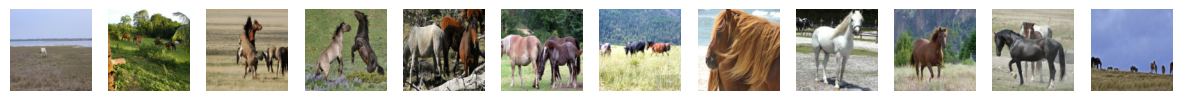

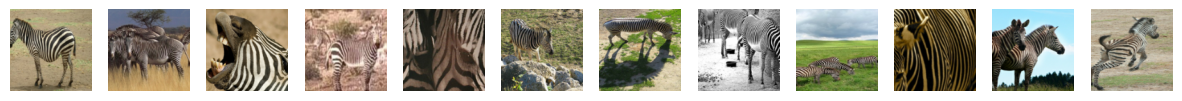

In [8]:
# Verify "get_x_train" output
def cvtImg(x):
    return (x + 1.0) / 2.0

def show(x, S=12):
    x = cvtImg(x)
    plt.figure(figsize=(15, 3))
    for i in range(min(len(x), S)):
        plt.subplot(1, S, i + 1)
        plt.imshow(x[i])
        plt.axis('off')
    plt.show()

for _ in range(1):
    xa, xb = get_x_train()
    xa = xa.numpy()
    print(xa.min(), xa.max(), xa.shape)
    show(xa)
    show(xb.numpy())

In [9]:
base_model = tf.keras.applications.VGG16(input_shape=(img_size, img_size, 3), include_top=False)

x = x_input = base_model.input

outputs = [
    'block2_conv2',
    'block3_conv3',
    'block4_conv3',
    'block5_conv1',
    'block5_pool',
]

x_output = [base_model.get_layer(n).output for n in outputs]
base_model = tf.keras.models.Model(x_input, x_output)

base_model.trainable = False

# base_model.summary() # if you want see more detail about VGG16

58889256/58889256 [==============================] - 3s 0us/step


In [10]:
act_name = 'gelu'

def act(x):
    x = layers.LayerNormalization()(x)
    x = layers.Activation(act_name)(x)
    return x

In [11]:
def conv_with_cmd(x_img_input, x_cmd, f=64, sp=4):
    x = layers.Dense(128)(x_cmd)
    x = layers.BatchNormalization()(x)
    x = layers.Activation(act_name)(x)

    x = layers.Dense(f)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('sigmoid')(x)

    x_g = layers.Reshape((1, 1, f))(x)

    # ---

    x = layers.Conv2D(f, kernel_size=3, padding='same')(x_img_input)
    x = layers.BatchNormalization()(x)
    x = layers.Activation(act_name)(x)
    x =  x * x_g


    return x

In [14]:
def create_dis_model():
    x = x_input = layers.Input(shape=(img_size, img_size, 3))

    [x64, x32, x16, x8, x4] = base_model(x_input)

    x = x8
    x = layers.Conv2D(512, kernel_size=3, padding='same')(x)
    x = act(x)
    x = layers.MaxPool2D()(x)

    x = layers.Concatenate()([x, x4])
    x = layers.Conv2D(512, kernel_size=3, padding='same')(x)
    x = act(x)

    x = layers.GlobalMaxPool2D()(x)

    x = layers.Dense(384)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation(act_name)(x)

    x = layers.Dense(128)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation(act_name)(x)

    x = layers.Dense(4)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('softmax')(x)

    return tf.keras.models.Model(x_input, x)

dis = create_dis_model()
# dis.summary() # if you want see more detail about model

In [15]:
y_false_a = np.zeros(batch_size)
y_false_b = np.full_like(y_false_a, 1)
y_true_a = np.full_like(y_false_a, 2)
y_true_b = np.full_like(y_false_a, 3)

In [21]:
opt_gen = tf.keras.optimizers.AdamW(learning_rate=LR)
opt_dis = tf.keras.optimizers.AdamW(learning_rate=LR)